In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
stock_data = pd.read_csv("data/HistoricalQuotes.csv")

In [3]:
stock_data.head(2)

,date,close,volume,open,high,low
0,5/9/19,1162.38,1185973,1166.27,1169.660,1150.85
1,5/8/19,1166.27,1309514,1174.10,1180.424,1165.74


In [4]:
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 6 columns):
date      1259 non-null object
close     1259 non-null float64
volume    1259 non-null int64
open      1259 non-null float64
high      1259 non-null float64
low       1259 non-null float64
dtypes: float64(4), int64(1), object(1)
memory usage: 59.1+ KB


In [5]:
import math
stock_data["average"] = (stock_data["high"] + stock_data["low"])/2
stock_data.head(2)

,date,close,volume,open,high,low,average
0,5/9/19,1162.38,1185973,1166.27,1169.660,1150.85,1160.255
1,5/8/19,1166.27,1309514,1174.10,1180.424,1165.74,1173.082


In [6]:
input_feature= stock_data.iloc[:,[2,6]].values
input_data = input_feature

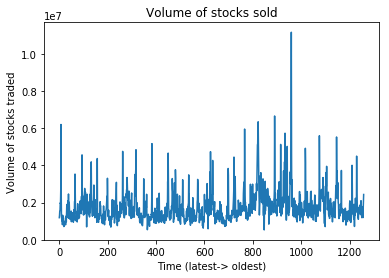

In [7]:
plt.plot(input_feature[:,0])
plt.title("Volume of stocks sold")
plt.xlabel("Time (latest-> oldest)")
plt.ylabel("Volume of stocks traded")
plt.show()

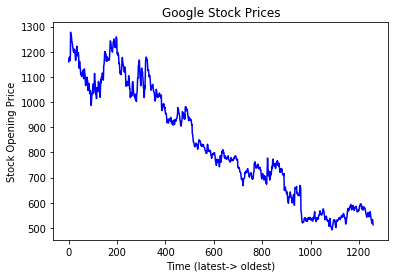

In [8]:
plt.plot(input_feature[:,1], color='blue')
plt.title("Google Stock Prices")
plt.xlabel("Time (latest-> oldest)")
plt.ylabel("Stock Opening Price")
plt.show()

In [9]:
from sklearn.preprocessing import MinMaxScaler
sc= MinMaxScaler(feature_range=(0,1))
input_data[:,0:2] = sc.fit_transform(input_feature[:,:])

In [10]:
input_data

array([[0.06199255, 0.85047673],
       [0.07361854, 0.86679577],
       [0.09637853, 0.87017739],
       ...,
       [0.10526283, 0.05218988],
       [0.12977123, 0.04177022],
       [0.17922778, 0.0258036 ]])

In [11]:
lookback= 50

In [12]:
X=[]
y=[]
for i in range(len(stock_data)-lookback-1):
    t=[]
    for j in range(0,lookback):
        
        t.append(input_data[[(i+j)], :])
    X.append(t)
    y.append(input_data[i+ lookback,1])

In [13]:
y

[0.7858914044137482,
 0.7861776586931704,
 0.7902361082547527,
 0.7781689000755647,
 0.7766549329977328,
 0.7920681356430532,
 0.7941037216300539,
 0.800738459706434,
 0.7984198000431162,
 0.8076785356808642,
 0.7936298117674552,
 0.7730576708863302,
 0.7645686411999166,
 0.7679909701405616,
 0.8118387645417966,
 0.814591894589215,
 0.8004203993959649,
 0.7928314803881786,
 0.7819220117390968,
 0.747005350855827,
 0.7299348631567777,
 0.7399762179944656,
 0.7584364384140772,
 0.7357619188807534,
 0.7386276422780778,
 0.7451796846737357,
 0.7733420168038894,
 0.7517444494818128,
 0.7558251632651283,
 0.7276291167420648,
 0.7056161626545159,
 0.7180014311441729,
 0.7285642140548432,
 0.7413947669791565,
 0.7388884517326622,
 0.7285005383806873,
 0.7090975872008456,
 0.6917900809584352,
 0.6898689966832032,
 0.6951233530121486,
 0.7029921650931479,
 0.6726046830309544,
 0.661224485122379,
 0.6298319324791037,
 0.6451369946188648,
 0.6660462794290867,
 0.6911539603374977,
 0.69170738527771

In [14]:
y[0:2]

[0.7858914044137482, 0.7861776586931704]

In [15]:
input_data[50:52]

array([[0.04151398, 0.7858914 ],
       [0.0886988 , 0.78617766]])

In [16]:
len(y)

1208

In [17]:
len(X[0])

50

In [18]:
len(X[0][0])

1

In [19]:
len(X)

1208

In [20]:
y[0]

0.7858914044137482

In [21]:
X[1]

[array([[0.07361854, 0.86679577]]),
 array([[0.09637853, 0.87017739]]),
 array([[0.09756192, 0.87375875]]),
 array([[0.13677697, 0.87292543]]),
 array([[0.13340458, 0.85599953]]),
 array([[0.19910642, 0.87256284]]),
 array([[0.53334465, 0.88056524]]),
 array([[0.17744361, 1.        ]]),
 array([[0.06597353, 0.98589409]]),
 array([[0.05386562, 0.97701912]]),
 array([[0.04590347, 0.97929116]]),
 array([[0.07001248, 0.97443756]]),
 array([[0.02628898, 0.9502777 ]]),
 array([[0.07419842, 0.94977516]]),
 array([[0.06442924, 0.94453989]]),
 array([[0.03087017, 0.93344594]]),
 array([[0.06212242, 0.9222312 ]]),
 array([[0.03760263, 0.91787371]]),
 array([[0.01714561, 0.90618818]]),
 array([[0.01856727, 0.90118191]]),
 array([[0.0318261 , 0.89809672]]),
 array([[0.03131351, 0.90648079]]),
 array([[0.03517008, 0.91455952]]),
 array([[0.03978242, 0.91363715]]),
 array([[0.04582715, 0.91172879]]),
 array([[0.02574721, 0.89281056]]),
 array([[0.06220542, 0.88746715]]),
 array([[0.06985984, 0.86406

In [22]:
X, y= np.array(X), np.array(y)

In [23]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
# test_size=int(.3 * len(stock_data))

In [24]:
X_train.shape

(809, 50, 1, 2)

In [25]:
X_train = X_train.reshape(X_train.shape[0],lookback, 2)

In [26]:
X_train.shape

(809, 50, 2)

In [27]:
X_test = X_test.reshape(X_test.shape[0],lookback, 2)


In [28]:
X_test.shape

(399, 50, 2)

In [29]:
y_test.shape

(399,)

In [30]:
from keras import Sequential
from keras.layers import Dense, LSTM

Using TensorFlow backend.


In [ ]:
model = Sequential()
model.add(LSTM(units=30, return_sequences= True, input_shape=(X.shape[1],2)))
model.add(LSTM(units=30, return_sequences=True))
model.add(LSTM(units=30))
model.add(Dense(units=1))
model.summary()

In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
model.fit(X_train, y_train, epochs=10, batch_size=32)

In [ ]:
predicted_value= model.predict(X_test)

In [ ]:
plt.plot(predicted_value, color= 'red')
plt.plot(y_test, color='green')
plt.title("Opening price of stocks sold")
plt.xlabel("Time (latest-> oldest)")
plt.ylabel("Stock Opening Price")
plt.show()

In [31]:
'''
Understanding return_sequences and return_state.
https://machinelearningmastery.com/return-sequences-and-return-states-for-lstms-in-keras/
Both are important to use in an encoder-decoder.
'''
from keras.models import Model
from keras.layers import Input
from keras.layers import LSTM
from numpy import array
# define model
inputs1 = Input(shape=(3, 1))
lstm1, state_h, state_c = LSTM(1, return_sequences=True, return_state=True)(inputs1)
model = Model(inputs=inputs1, outputs=[lstm1, state_h, state_c])
# define input data
data = array([0.1, 0.2, 0.3]).reshape((1,3,1))
# make and show prediction
print(model.predict(data))

Instructions for updating:
Colocations handled automatically by placer.
[array([[[-0.02259852],
        [-0.06335121],
        [-0.11654004]]], dtype=float32), array([[-0.11654004]], dtype=float32), array([[-0.26822603]], dtype=float32)]


# LSTM Autoencoder

In [43]:
from keras import optimizers
from keras.utils import plot_model
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed

In [46]:
serie_size =  X_train.shape[1] # 12
n_features =  X_train.shape[2] # 1

In [47]:
n_features

2

In [34]:
epochs = 15
batch = 64
lr = 0.0001

In [39]:
lstm_model = Sequential()
lstm_model.add(LSTM(10, input_shape=(serie_size, n_features), return_sequences=True))
lstm_model.add(LSTM(6, activation='relu', return_sequences=True))
lstm_model.add(LSTM(1, activation='relu'))
lstm_model.add(Dense(10, kernel_initializer='glorot_normal', activation='relu'))
lstm_model.add(Dense(10, kernel_initializer='glorot_normal', activation='relu'))
lstm_model.add(Dense(1))
lstm_model.summary()

adam = optimizers.Adam(lr)
lstm_model.compile(loss='mse', optimizer=adam)

'''
pip install pydot
brew install graphviz
'''
# plot_model(lstm_model, show_shapes=True, to_file='regular_lstm.png')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_14 (LSTM)               (None, 50, 10)            520       
_________________________________________________________________
lstm_15 (LSTM)               (None, 50, 6)             408       
_________________________________________________________________
lstm_16 (LSTM)               (None, 1)                 32        
_________________________________________________________________
dense_13 (Dense)             (None, 10)                20        
_________________________________________________________________
dense_14 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 11        
Total params: 1,101
Trainable params: 1,101
Non-trainable params: 0
_________________________________________________________________


'\npip install pydot\nbrew install graphviz\n'

In [41]:
lstm_history = lstm_model.fit(X_train, y_train, epochs=epochs, batch_size=batch, validation_data=(X_test, y_test), verbose=2)

Instructions for updating:
Use tf.cast instead.
Train on 809 samples, validate on 399 samples
Epoch 1/15
 - 4s - loss: 0.2380 - val_loss: 0.2476
Epoch 2/15
 - 2s - loss: 0.2343 - val_loss: 0.2437
Epoch 3/15
 - 2s - loss: 0.2302 - val_loss: 0.2384
Epoch 4/15
 - 2s - loss: 0.2228 - val_loss: 0.2256
Epoch 5/15
 - 2s - loss: 0.2035 - val_loss: 0.1970
Epoch 6/15
 - 2s - loss: 0.1762 - val_loss: 0.1689
Epoch 7/15
 - 2s - loss: 0.1506 - val_loss: 0.1436
Epoch 8/15
 - 2s - loss: 0.1273 - val_loss: 0.1208
Epoch 9/15
 - 2s - loss: 0.1069 - val_loss: 0.1004
Epoch 10/15
 - 2s - loss: 0.0884 - val_loss: 0.0833
Epoch 11/15
 - 2s - loss: 0.0728 - val_loss: 0.0673
Epoch 12/15
 - 2s - loss: 0.0580 - val_loss: 0.0522
Epoch 13/15
 - 2s - loss: 0.0439 - val_loss: 0.0384
Epoch 14/15
 - 2s - loss: 0.0313 - val_loss: 0.0263
Epoch 15/15
 - 2s - loss: 0.0209 - val_loss: 0.0172


In [48]:
encoder_decoder = Sequential()
encoder_decoder.add(LSTM(serie_size, activation='relu', input_shape=(serie_size, n_features), return_sequences=True))
encoder_decoder.add(LSTM(6, activation='relu', return_sequences=True))
encoder_decoder.add(LSTM(1, activation='relu'))
encoder_decoder.add(RepeatVector(serie_size))
encoder_decoder.add(LSTM(serie_size, activation='relu', return_sequences=True))
encoder_decoder.add(LSTM(6, activation='relu', return_sequences=True))
encoder_decoder.add(TimeDistributed(Dense(n_features)))
encoder_decoder.summary()

adam = optimizers.Adam(lr)
encoder_decoder.compile(loss='mse', optimizer=adam)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_25 (LSTM)               (None, 50, 50)            10600     
_________________________________________________________________
lstm_26 (LSTM)               (None, 50, 6)             1368      
_________________________________________________________________
lstm_27 (LSTM)               (None, 1)                 32        
_________________________________________________________________
repeat_vector_2 (RepeatVecto (None, 50, 1)             0         
_________________________________________________________________
lstm_28 (LSTM)               (None, 50, 50)            10400     
_________________________________________________________________
lstm_29 (LSTM)               (None, 50, 6)             1368      
_________________________________________________________________
time_distributed_2 (TimeDist (None, 50, 2)             14        
Total para

In [49]:
encoder_decoder_history = encoder_decoder.fit(X_train, X_train, epochs=epochs, batch_size=batch, verbose=2)

Epoch 1/15
 - 7s - loss: 0.1356
Epoch 2/15
 - 3s - loss: 0.1322
Epoch 3/15
 - 2s - loss: 0.1285
Epoch 4/15
 - 2s - loss: 0.1245
Epoch 5/15
 - 2s - loss: 0.1201
Epoch 6/15
 - 2s - loss: 0.1153
Epoch 7/15
 - 2s - loss: 0.1099
Epoch 8/15
 - 2s - loss: 0.1039
Epoch 9/15
 - 2s - loss: 0.0968
Epoch 10/15
 - 2s - loss: 0.0884
Epoch 11/15
 - 2s - loss: 0.0777
Epoch 12/15
 - 3s - loss: 0.0638
Epoch 13/15
 - 3s - loss: 0.0486
Epoch 14/15
 - 3s - loss: 0.0376
Epoch 15/15
 - 3s - loss: 0.0319


In [51]:
rpt_vector_layer = Model(inputs=encoder_decoder.inputs, outputs=encoder_decoder.layers[3].output)
time_dist_layer = Model(inputs=encoder_decoder.inputs, outputs=encoder_decoder.layers[5].output)
encoder_decoder.layers

In [62]:
rpt_vector_layer.predict(X_train)[0]

array([[0.14445814],
       [0.14445814],
       [0.14445814],
       [0.14445814],
       [0.14445814],
       [0.14445814],
       [0.14445814],
       [0.14445814],
       [0.14445814],
       [0.14445814],
       [0.14445814],
       [0.14445814],
       [0.14445814],
       [0.14445814],
       [0.14445814],
       [0.14445814],
       [0.14445814],
       [0.14445814],
       [0.14445814],
       [0.14445814],
       [0.14445814],
       [0.14445814],
       [0.14445814],
       [0.14445814],
       [0.14445814],
       [0.14445814],
       [0.14445814],
       [0.14445814],
       [0.14445814],
       [0.14445814],
       [0.14445814],
       [0.14445814],
       [0.14445814],
       [0.14445814],
       [0.14445814],
       [0.14445814],
       [0.14445814],
       [0.14445814],
       [0.14445814],
       [0.14445814],
       [0.14445814],
       [0.14445814],
       [0.14445814],
       [0.14445814],
       [0.14445814],
       [0.14445814],
       [0.14445814],
       [0.144

In [65]:
time_dist_layer.predict(X_train).shape

(809, 50, 6)

In [66]:
encoder = Model(inputs=encoder_decoder.inputs, outputs=encoder_decoder.layers[2].output)

In [68]:
train_encoded = encoder.predict(X_train)
validation_encoded = encoder.predict(X_test)
print('Encoded time-series shape', train_encoded.shape)
print('Encoded time-series sample', train_encoded[0])

Encoded time-series shape (809, 1)
Encoded time-series sample [0.14445814]


In [69]:
train['encoded'] = train_encoded
train['label'] = y_train

valid['encoded'] = validation_encoded
valid['label'] = y_test

NameError: name 'train' is not defined

# Reading and data pre-processing

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from pylab import rcParams
import tensorflow as tf
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)
SEED = 123 #used to help randomly select the data points
DATA_SPLIT_PCT = 0.2
rcParams['figure.figsize'] = 8, 6
LABELS = ["Normal","Break"]

Using TensorFlow backend.


In [6]:
'''
Clean the data.
Curve shifting.
'''
df = pd.read_csv("data/processminer-rare-event-mts - data.csv")

In [8]:
df.head(n=5)  # visualize the data.

,time,y,x1,x2,x3,x4,x5,x6,x7,x8,...,x52,x53,x54,x55,x56,x57,x58,x59,x60,x61
0,5/1/99 0:00,0,0.376665,-4.596435,-4.095756,13.497687,-0.118830,-20.669883,0.000732,-0.061114,...,10.091721,0.053279,-4.936434,-24.590146,18.515436,3.473400,0.033444,0.953219,0.006076,0
1,5/1/99 0:02,0,0.475720,-4.542502,-4.018359,16.230659,-0.128733,-18.758079,0.000732,-0.061114,...,10.095871,0.062801,-4.937179,-32.413266,22.760065,2.682933,0.033536,1.090502,0.006083,0
2,5/1/99 0:04,0,0.363848,-4.681394,-4.353147,14.127998,-0.138636,-17.836632,0.010803,-0.061114,...,10.100265,0.072322,-4.937924,-34.183774,27.004663,3.537487,0.033629,1.840540,0.006090,0
3,5/1/99 0:06,0,0.301590,-4.758934,-4.023612,13.161567,-0.148142,-18.517601,0.002075,-0.061114,...,10.104660,0.081600,-4.938669,-35.954281,21.672449,3.986095,0.033721,2.554880,0.006097,0
4,5/1/99 0:08,0,0.265578,-4.749928,-4.333150,15.267340,-0.155314,-17.505913,0.000732,-0.061114,...,10.109054,0.091121,-4.939414,-37.724789,21.907251,3.601573,0.033777,1.410494,0.006105,0


# Preparing data for LSTM

In [3]:
'''
prepare the 3d arrays
'''


'\nprepare the 3d arrays\n'

LSTM autoencoder and fitting

Assess the result

understand the meaning of the layers.

In the next, we will learn tuning the model: GaussianDropout, SELU-AlphaDropout, CNN layer.

Curve shifting